# Multi-label Patent Classification with Neural Networks

In [225]:
# import packages 
import tensorflow as tf
import pandas as pd  
import numpy as np 
import gzip
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Input, Embedding, Reshape, Flatten, Conv1D, MaxPooling1D, MaxPool1D, GlobalMaxPool1D, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras import utils
from keras import optimizers, models
from sklearn import model_selection, preprocessing, metrics
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import zipfile
import keras_metrics

import nltk
import re

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Loading the Data

Dataset: 

https://www.google.com/googlebooks/uspto-patents-grants-text.html#2015

The parsing and preprocessing of the patent files can be found here: 

https://github.com/cpapadimitriou/W266-Final-Project/blob/master/preparation/parse_xml.py

In [3]:
# load data 

# features 
current_dir = %pwd
abstract = pd.read_table(current_dir+'/out_zipped/docNumberToAbsText.txt.gz',compression='gzip', header=None)
abstract = abstract[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'abstract'})

claim = pd.read_table(current_dir+'/out_zipped/docNumberToClaimText.txt.gz',compression='gzip',  header=None)
claim = claim[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'claim'})

desc = pd.read_table(current_dir+'/out_zipped/docNumberToDescText.txt.gz',compression='gzip', header=None)
desc = desc[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'desc'})

title = pd.read_table(current_dir+'/out_zipped/docNumberToInvTitle.txt.gz',compression='gzip', header=None)
title = title[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'title'})

# file_name = pd.read_table(current_dir+'/out_zipped/fileNameToDocNumber.txt.gz',compression='gzip', header=None)
# file_name = file_name[0].str.split('|', expand=True).rename(columns={0:'file_name',1:'doc_num'})

In [4]:
# labels 
# label_names = pd.read_table(current_dir+'/out_zipped/docNumberToLabelSubClass.txt.gz',compression='gzip', header=None)
# label_names = labels[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

labels = pd.read_table(current_dir+'/out_zipped/docNumberToLabelSubClassCode.txt.gz',compression='gzip', header=None)
labels = labels[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

### Data Preparation

In [5]:
# joining the datasets
X = pd.concat([title.set_index('doc_num'), 
           abstract.set_index('doc_num'), 
           claim.set_index('doc_num'), 
           desc.set_index('doc_num')], axis=1).sort_index() #  join='inner'

Y = labels.set_index('doc_num').sort_index() #.set_index(X.index) # fixing the index mismatch
Y.columns=["label{}".format(i) for i in range(1,9)] # renaming columns 

print(X.shape)
print(Y.shape)

(78372, 4)
(78372, 8)


In [6]:
X.head()

,title,abstract,claim,desc
doc_num,,,,
0000001,INTEGRAL MULTIFUNCTIONAL SYSTEM FOR MOTOR VEHICLE,The system finds application with the motor ve...,CLAIMS 1. Integral multifunctional system for ...,INTEGRAL MULTIFUNCTIONAL SYSTEM FOR MOTOR VEHI...
0000002,TURBINE DRIVEN WITH A FLUID MEDIUM,Turbine driven by a flowing medium to generate...,Claims 1. Turbine driven by a flowing medium t...,TURBINE DRIVEN WITH A FLUID MEDIUM. Technical ...
0000003,METHOD TO REMOVE LEAKAGE PROBLEMS IN PIPES PRO...,Method to remove leakage problems in pipes pro...,CLAIMS Claim 1 ) A new method in which choke a...,SPECIFICATION METHOD TO REMOVE LEAKAGE PROBLEM...
0000004,PRESSURE RELEASE VALVE,A pressure release valve is disclosed ideally ...,CLAIMS 1. A pressure release valve comprising ...,Pressure Release Valve This invention relates ...
0000005,ROLL-OVER MECHANISM FOR A PRESSURE RELEASE VALVE,A rollover mechanism for a pressure valve is d...,"CLAIMS 1. A roll-over mechanism for a valve, s...",Roll-over mechanism for a pressure release val...


In [7]:
Y.head()

,label1,label2,label3,label4,label5,label6,label7,label8
doc_num,,,,,,,,
0000001,F02B,None,None,None,None,None,None,None
0000002,F03D,F03B,None,None,None,None,None,None
0000003,F16L,None,None,None,None,None,None,None
0000004,F16K,None,None,None,None,None,None,None
0000005,F16K,None,None,None,None,None,None,None


In [8]:
# data cleaning 
assert Y['label1'].isnull().sum() == 0 # there is no document with 

print("{} documents with null title".format(X['title'].isnull().sum()))
print("{} documents with null claims".format(X['claim'].isnull().sum()))
print("{} documents with null abstract".format(X['abstract'].isnull().sum()))
print("{} documents with null description".format(X['desc'].isnull().sum()))

# remove documents with null sections (title and abstract)
X_clean = X.dropna(how='any')
null_idx = X[~X.index.isin(X_clean.index)].index # storing the removed indices (i.e. document numbers)
assert X.shape[0] - null_idx.shape[0] == X_clean.shape[0] # making sure the row counts match

# removing the documents with null sections from the labels as well 
Y_clean = Y.loc[X_clean.index]

# some checks
assert X_clean.shape[0] == Y_clean.shape[0]
assert ((Y_clean.index == X_clean.index)*1).sum() == X_clean.shape[0]

# lower-casing everything
X_clean = X_clean.apply(lambda x: x.str.lower())
Y_clean = Y_clean.apply(lambda x: x.str.lower())

0 documents with null title
0 documents with null claims
0 documents with null abstract
0 documents with null description


In [9]:
print(X_clean.shape)
print(Y_clean.shape)

(78372, 4)
(78372, 8)


In [10]:
X_clean.head()

,title,abstract,claim,desc
doc_num,,,,
0000001,integral multifunctional system for motor vehicle,the system finds application with the motor ve...,claims 1. integral multifunctional system for ...,integral multifunctional system for motor vehi...
0000002,turbine driven with a fluid medium,turbine driven by a flowing medium to generate...,claims 1. turbine driven by a flowing medium t...,turbine driven with a fluid medium. technical ...
0000003,method to remove leakage problems in pipes pro...,method to remove leakage problems in pipes pro...,claims claim 1 ) a new method in which choke a...,specification method to remove leakage problem...
0000004,pressure release valve,a pressure release valve is disclosed ideally ...,claims 1. a pressure release valve comprising ...,pressure release valve this invention relates ...
0000005,roll-over mechanism for a pressure release valve,a rollover mechanism for a pressure valve is d...,"claims 1. a roll-over mechanism for a valve, s...",roll-over mechanism for a pressure release val...


In [11]:
Y_clean.head()

,label1,label2,label3,label4,label5,label6,label7,label8
doc_num,,,,,,,,
0000001,f02b,None,None,None,None,None,None,None
0000002,f03d,f03b,None,None,None,None,None,None
0000003,f16l,None,None,None,None,None,None,None
0000004,f16k,None,None,None,None,None,None,None
0000005,f16k,None,None,None,None,None,None,None


In [12]:
# Creating dataset 
data = pd.DataFrame()

# concat the text of all patent sections and join the labels
data['full_text'] = X_clean['title'] + " " + X_clean['claim'] + " " + X_clean['abstract'] + " " + X_clean['desc']

# using only the first label  
data['label1'] = Y_clean['label1'] 

# using all labels, merging them in a list and removing None values
data['labels'] = Y_clean.values.tolist()
data['labels'] = data['labels'].apply(lambda x: list(filter(None, x)))

In [13]:
data.head()

,full_text,label1,labels
doc_num,,,
0000001,integral multifunctional system for motor vehi...,f02b,[f02b]
0000002,turbine driven with a fluid medium claims 1. t...,f03d,"[f03d, f03b]"
0000003,method to remove leakage problems in pipes pro...,f16l,[f16l]
0000004,pressure release valve claims 1. a pressure re...,f16k,[f16k]
0000005,roll-over mechanism for a pressure release val...,f16k,[f16k]


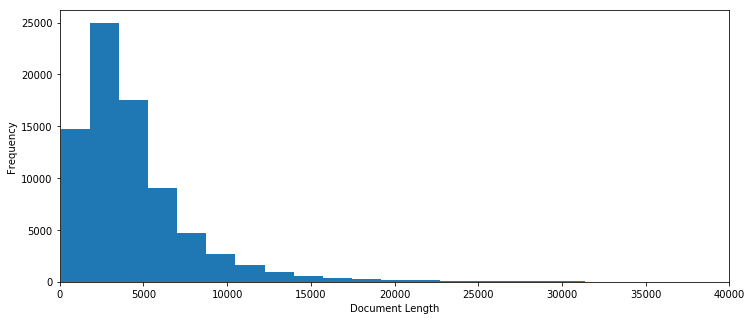

In [14]:
# histogram of document length 
doc_lenghts = data.full_text.str.split().apply(lambda x: len(x))
plt.figure(figsize=(12,5))
plt.hist(doc_lenghts, bins=100)
plt.xlim((0,40000))
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Bokeh for plotting.
import bokeh.plotting as bp
from bokeh.models import HoverTool
bp.output_notebook()

# Helper code for plotting histograms
def plot_length_histogram(lengths, x_range=[0,40000], bins=40, normed=False):
    hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths =  (bin_edges[1:] - bin_edges[:-1])

    hover = HoverTool(tooltips=[("bucket", "@x"), ("count", "@top")], mode="vline")
    fig = bp.figure(plot_width=800, plot_height=400, tools=[hover])
    fig.vbar(x=bin_centers, width=bin_widths, top=hist, hover_fill_color="firebrick")
    fig.y_range.start = 0
    fig.x_range.start = 0
    fig.xaxis.axis_label = "Document Length"
    fig.yaxis.axis_label = "Frequency"
    bp.output_file("hist.html")
    bp.show(fig)
    
plot_length_histogram(doc_lenghts)

In [15]:
# examing the document length 
print("Average document length: {} words".format(round(np.mean(doc_lenghts))))
print("Median document length: {} words".format(round(np.median(doc_lenghts))))
print("Max document length: {} words".format(round(np.max(doc_lenghts))))
print("Min document length: {} words".format(round(np.min(doc_lenghts))))

Average document length: 4433 words
Median document length: 3488.0 words
Max document length: 174233 words
Min document length: 48 words


In [16]:
# average number of labels per document 
print("Avg. number of labels in dataset: {}".format(data['labels'].apply(lambda x: len(x)).mean()))

Avg. number of labels in dataset: 1.394949726943296


#### Note: we remove documents with less than 200 words

In [24]:
# filtering out documents with fewer words 
data["doc_lenghts"] = data.full_text.str.split().apply(lambda x: len(x))

In [29]:
data[data["doc_lenghts"]<200].shape

(195, 4)

In [23]:
data.shape

(78372, 4)

In [31]:
data = data[data["doc_lenghts"]>200]

In [32]:
data.shape

(78172, 4)

### Encoding Labels with MultiLabelBinarizer

In [34]:
data['labels'].head()

doc_num
0000001          [f02b]
0000002    [f03d, f03b]
0000003          [f16l]
0000004          [f16k]
0000005          [f16k]
Name: labels, dtype: object

In [35]:
# converting labels into a binarized matrix with the labels as columns 
# and each patent document represented in one row
mlb = preprocessing.MultiLabelBinarizer()
labels = mlb.fit_transform(data['labels'])

# checking that the conversion worked as desired by verifying the counts of labels for each document prior and post 
assert data['labels'].apply(lambda x: len(x)).values.sum() == np.array(pd.DataFrame(labels).apply(lambda x: x.sum(),axis=1)).sum()

In [36]:
# labels_df.iloc[:,[538]].sum()   #470

In [37]:
labels_df = pd.DataFrame(labels, columns=mlb.classes_)  #.apply(lambda x: x.sum(),axis=1)
labels_df.head()

,f01b,f01c,f01d,f01k,f01l,f01m,f01n,f01p,f02b,f02c,...,f41a,f41b,f41c,f41f,f41g,f41h,f41j,f42b,f42c,f42d
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
print("We have {} classes".format(len(mlb.classes_)))
# print("")
# for i in mlb.classes_: 
#     print(i)

We have 96 classes


In [39]:
# checking how many times does each label (i.e. class) appear in the data 
# we observe that the classes are a little unbalanced 
pl = labels_df.apply(lambda x: x.sum(),axis=0).sort_values(ascending=False)  #.plot.bar()
pl

f16h    6030
f16l    5606
f02b    5209
f16k    4528
f02d    4504
f16d    4265
f02m    4262
f16c    3541
f16b    3447
f04b    3311
f16f    2928
f21v    2541
f25b    2489
f16j    2466
f01n    2366
f28f    2187
f01d    2170
f04d    2138
f24f    2009
f15b    1983
f28d    1883
f02c    1838
f01l    1696
f25d    1682
f04c    1635
f02f    1461
f27d    1293
f26b    1267
f21s    1241
f23d    1161
        ... 
f23m     255
f25c     254
f03b     250
f42c     233
f04f     205
f16p     186
f28g     180
f15c     167
f41b     167
f42d     160
f24b     154
f03c     147
f21w     139
f15d     134
f21l     134
f28c     131
f41j     125
f21k     123
f41c      98
f28b      94
f41f      84
f16t      77
f22d      58
f03h      52
f23h      50
f16s      47
f22g      40
f23b      34
f21h       6
f17b       6
Length: 96, dtype: int64

In [ ]:
from bokeh.io import show, output_file
from bokeh.plotting import figure
import bokeh.plotting as bp
bp.output_notebook()

output_file("bars.html")
p = figure(x_range=list(pl.index), plot_height=250, title="Label Counts",
           toolbar_location=None, tools="")
p.vbar(x=list(pl.index), top=pl.values, width=0.1)
p.xgrid.grid_line_color = None
p.y_range.start = 0
show(p)

### Advanced text processing and TF_IDF 
The following processing was applied to `data['full_text']`:

- removing punctuation 
- lowercasing (happened earlier no need to do it here)
- ** Detect and Remove non-english documents - TO DO **
- removing stop words 
- romoving common / rare words (did not run this)
- lemmatization or stemming (we chose lemmatization)
- remove digits
- filtering 600 best words in each document based on tf_idf algorithm 

In [41]:
data['full_text'].head(10)

doc_num
0000001    integral multifunctional system for motor vehi...
0000002    turbine driven with a fluid medium claims 1. t...
0000003    method to remove leakage problems in pipes pro...
0000004    pressure release valve claims 1. a pressure re...
0000005    roll-over mechanism for a pressure release val...
0000007    device by ball valve c l a i m s 1. a valve, i...
0000008    composite electroconducting material claims 1....
0000009    process and apparatus for agglomeration of pow...
0000011    heating unit for rock material claims 1. a hea...
0000012    a method and apparatus for microwave processin...
Name: full_text, dtype: object

### 1. Advanced Processing

In [42]:
# removing punctuation 
data['full_text_proc'] = data['full_text'].str.replace('[^\w\s]','')
data['full_text_proc'].head(10)

doc_num
0000001    integral multifunctional system for motor vehi...
0000002    turbine driven with a fluid medium claims 1 tu...
0000003    method to remove leakage problems in pipes pro...
0000004    pressure release valve claims 1 a pressure rel...
0000005    rollover mechanism for a pressure release valv...
0000007    device by ball valve c l a i m s 1 a valve in ...
0000008    composite electroconducting material claims 1 ...
0000009    process and apparatus for agglomeration of pow...
0000011    heating unit for rock material claims 1 a heat...
0000012    a method and apparatus for microwave processin...
Name: full_text_proc, dtype: object

In [ ]:
# lower - casing 
data['full_text_proc'] = data['full_text_proc'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [43]:
# removing stop words 

nltk.download('stopwords')
# stop = nltk.corpus.stopwords.words('english')
# data['full_text_proc'] = data['full_text_proc'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# data['full_text_proc'].head()
stop = nltk.corpus.stopwords.words('english')
pattern_stop = r'\b(?:{})\b'.format('|'.join(stop))
data['full_text_proc_no_stop'] = data['full_text_proc'].str.replace(pattern_stop, '')
data['full_text_proc_no_stop'] = data['full_text_proc_no_stop'].str.replace(r'\s+', ' ')
data['full_text_proc'] = data['full_text_proc_no_stop']

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/c.papadimitriou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Note: we will not run common and rare word removal cells. This will be taken care of with TF-IDF later. 

In [ ]:
# Common word removal 
# we can remove common words as their presence will not be of any use for our classification problem 
freq_words = pd.Series(' '.join(data['full_text_proc']).split()).value_counts()[:10] # chose the number here 
freq_words

In [ ]:
# Decide if we want to remove these
freq_words = list(freq_words.index)
pattern_freq_words = r'\b(?:{})\b'.format('|'.join(freq_words))

data['full_text_proc'] = data['full_text_proc'].replace(to_replace=pattern_freq_words, value="",regex=True)
data['full_text_proc'] = data['full_text_proc'].str.replace(r'\s+', ' ')

In [38]:
# Rare word removal 
# Similarly, just as we removed the most common words, this time let’s remove rarely occurring words from the text. 
# Because they’re so rare, the association between them and other words is dominated by noise. 
rare_words = pd.Series(' '.join(data['full_text_proc']).split()).value_counts()[-10:]
rare_words

tetrastearate    1
atmio16de10      1
carottier        1
tesse            1
rastlippen       1
9624705          1
albe             1
carimali         1
65gcm3           1
tremities        1
dtype: int64

In [41]:
rare_words = list(rare_words.index)
pattern_rare_words = r'\b(?:{})\b'.format('|'.join(rare_words))
data['full_text_proc'] = data['full_text_proc'].replace(to_replace=pattern_rare_words, value="",regex=True)
data['full_text_proc'] = data['full_text_proc'].str.replace(r'\s+', ' ')

In [21]:
data['full_text_proc'].head()

doc_num
0000001    integral multifunctional system motor vehicle ...
0000002    turbine driven fluid medium claims 1 turbine d...
0000003    method remove leakage problems pipes produced ...
0000004    pressure release valve claims 1 pressure relea...
0000005    rollover mechanism pressure release valve clai...
Name: full_text_proc, dtype: object

In [ ]:
# Spelling correction (this will take a while to run - lets think if we need it. Maybe fo the foreign language words?)
# Maybe there is another library to remove foreign language text? 

# from textblob import TextBlob
# data['full_text_proc'] = data['full_text_proc'][:5].apply(lambda x: str(TextBlob(x).correct()))

In [ ]:
# Stemming: removal of suffices, like “ing”, “ly”, “s”, etc.
# from nltk.stem import PorterStemmer
# st = PorterStemmer()
# data['full_text_proc'] = data['full_text_proc'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [48]:
# Lemmatization: converts the word into its root word, rather than just stripping the suffices.
# use this instead of stemming 
nltk.download('wordnet')

from textblob import Word
data['full_text_proc'] = data['full_text_proc'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['full_text_proc'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/c.papadimitriou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


doc_num
0000001    integral multifunctional system motor vehicle ...
0000002    turbine driven fluid medium claim 1 turbine dr...
0000003    method remove leakage problem pipe produced pl...
0000004    pressure release valve claim 1 pressure releas...
0000005    rollover mechanism pressure release valve clai...
Name: full_text_proc, dtype: object

In [51]:
# Remove Digits 
import re
data['full_text_proc'] = data['full_text_proc'].apply(lambda x : re.sub("\d+", "", x))

### PICKLE CHECKPOINT:

In [53]:
#[201808012200 PT]
data.to_pickle('./saved_df_zipped/data_after_advanced_proc.pkl.gz', compression='gzip')

#[201808012200 PT]
#data = pd.DataFrame()
#data = pd.read_pickle("./saved_df_zipped/data_after_advanced_proc.pkl.gz", compression='gzip')
#data.info()
#data.head

In [54]:
data.head()

,full_text,label1,labels,doc_lenghts,full_text_proc,full_text_proc_no_stop
doc_num,,,,,,
0000001,integral multifunctional system for motor vehi...,f02b,[f02b],6385,integral multifunctional system motor vehicle ...,integral multifunctional system motor vehicle ...
0000002,turbine driven with a fluid medium claims 1. t...,f03d,"[f03d, f03b]",3236,turbine driven fluid medium claim turbine dri...,turbine driven fluid medium claims 1 turbine d...
0000003,method to remove leakage problems in pipes pro...,f16l,[f16l],645,method remove leakage problem pipe produced pl...,method remove leakage problems pipes produced ...
0000004,pressure release valve claims 1. a pressure re...,f16k,[f16k],2967,pressure release valve claim pressure release...,pressure release valve claims 1 pressure relea...
0000005,roll-over mechanism for a pressure release val...,f16k,[f16k],3711,rollover mechanism pressure release valve clai...,rollover mechanism pressure release valve clai...


### 2. TF-IDF 

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [56]:
max_length = 600
col_names =  ['i','top_words']
data_tfidf  = pd.DataFrame(columns = col_names)

In [57]:
data['full_text_proc'].head()

doc_num
0000001    integral multifunctional system motor vehicle ...
0000002    turbine driven fluid medium claim  turbine dri...
0000003    method remove leakage problem pipe produced pl...
0000004    pressure release valve claim  pressure release...
0000005    rollover mechanism pressure release valve clai...
Name: full_text_proc, dtype: object

In [58]:
# TF-IDF to eliminate word count
# We can also perform basic pre-processing steps like lower-casing and removal of stopwords (but we did this earlier)

tfidf = TfidfVectorizer(lowercase=True, analyzer='word', smooth_idf=False, sublinear_tf=False, norm=None,
                        stop_words='english', ngram_range=(1,1)) 

text_transformed = tfidf.fit_transform(data['full_text_proc'])

In [59]:
import datetime
print(datetime.datetime.now())
feature_names = np.array(tfidf.get_feature_names())

for i in range(text_transformed.shape[0]):
    f_index = text_transformed[i,:].nonzero()[1]
    tfid_score = zip(f_index,[text_transformed[i,x] for x in f_index])
    
    word = []
    score = []

    for w,s in [(feature_names[i],s) for i,s in tfid_score]:
        word.append(w)
        score.append(s)
    score = np.array(score)
    word = np.array(word)
    txt = " ".join(word[(-score).argsort()[:max_length]])
    data_tfidf.loc[len(data_tfidf)] = [i,txt]
print(datetime.datetime.now())

2018-08-04 15:33:43.611360
2018-08-04 16:14:57.113929


In [61]:
data_tfidf.head()

,i,top_words
0,0,hydraulic accumulator microcomputer engine liq...
1,1,foil turbine longitual discoidal shaft angel m...
2,2,muff plasticbase choke pipe gasket clampsystem...
3,3,tanker valve rollover plunger pressure petrol ...
4,4,tanker rollover pendulum valve float petrol me...


In [72]:
data['full_text_proc_final'] = data_tfidf.set_index(data.index).top_words

In [166]:
data.head()

,full_text,label1,labels,doc_lenghts,full_text_proc,full_text_proc_no_stop,full_text_proc_final
doc_num,,,,,,,
0000001,integral multifunctional system for motor vehi...,f02b,[f02b],6385,integral multifunctional system motor vehicle ...,integral multifunctional system motor vehicle ...,hydraulic accumulator microcomputer engine liq...
0000002,turbine driven with a fluid medium claims 1. t...,f03d,"[f03d, f03b]",3236,turbine driven fluid medium claim turbine dri...,turbine driven fluid medium claims 1 turbine d...,foil turbine longitual discoidal shaft angel m...
0000003,method to remove leakage problems in pipes pro...,f16l,[f16l],645,method remove leakage problem pipe produced pl...,method remove leakage problems pipes produced ...,muff plasticbase choke pipe gasket clampsystem...
0000004,pressure release valve claims 1. a pressure re...,f16k,[f16k],2967,pressure release valve claim pressure release...,pressure release valve claims 1 pressure relea...,tanker valve rollover plunger pressure petrol ...
0000005,roll-over mechanism for a pressure release val...,f16k,[f16k],3711,rollover mechanism pressure release valve clai...,rollover mechanism pressure release valve clai...,tanker rollover pendulum valve float petrol me...


In [136]:
#data.reset_index()[data.reset_index().doc_num=='85110305']
# data.reset_index()[data.reset_index().doc_num=='0000007']
# data.reset_index()[data.reset_index().doc_num=='85110305'].full_text_proc_final.values
# data.reset_index()[data.reset_index().doc_num=='85110305'].full_text.values

### PICKLE CHECKPOINT:

In [76]:
#[201808012200 PT]
data.to_pickle('./saved_df_zipped/data_after_tfidf.pkl.gz', compression='gzip')

#[201808012200 PT]
#data = pd.DataFrame()
#data = pd.read_pickle("./saved_df_zipped/data_after_tfidf.pkl.gz", compression='gzip')
#data.info()
#data.head

In [ ]:
# OLD TFIDF ATTEMPT
# tfidf = TfidfVectorizer(lowercase=True, analyzer='word', smooth_idf=False, sublinear_tf=False, norm=None,
#                         stop_words='english', ngram_range=(1,1)) 

# text_transformed = tfidf.fit_transform(data['full_text_proc']).toarray() # CHANGE THIS TO ALL DOCS
# feature_names = np.array(tfidf.get_feature_names())
# test_words = feature_names[np.argsort(text_transformed)][:,-max_length:]

# z = []
# for i,t in (enumerate(list(test_words))):
#     a = (set(t))
#     b = (set(re.sub("[^\w]", " ",  (data['full_text_proc'][:20000][i])).split()))
#     z.append(list(a.intersection(b)))

# data['full_text_proc_final'] = pd.Series(z, index=data.index).apply(lambda x : " ".join(x))

#### Examining document length distribution after tfidf 

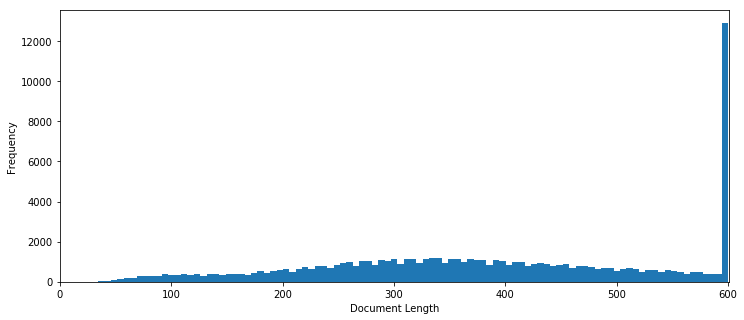

In [79]:
# histogram of document length 
doc_lenghts_tfidf = data.full_text_proc_final.str.split().apply(lambda x: len(x))
plt.figure(figsize=(12,5))
plt.hist(doc_lenghts_tfidf, bins=100)
plt.xlim((0,601))
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Bokeh for plotting.
import bokeh.plotting as bp
from bokeh.models import HoverTool
bp.output_notebook()

# Helper code for plotting histograms
def plot_length_histogram(lengths, x_range=[0,600], bins=40, normed=False):
    hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths =  (bin_edges[1:] - bin_edges[:-1])

    hover = HoverTool(tooltips=[("bucket", "@x"), ("count", "@top")], mode="vline")
    fig = bp.figure(plot_width=800, plot_height=400, tools=[hover])
    fig.vbar(x=bin_centers, width=bin_widths, top=hist, hover_fill_color="firebrick")
    fig.y_range.start = 0
    fig.x_range.start = 0
    fig.xaxis.axis_label = "Document Length"
    fig.yaxis.axis_label = "Frequency"
    bp.output_file("hist_tfidf.html")
    bp.show(fig)
    
plot_length_histogram(doc_lenghts_tfidf)

In [89]:
print("Average document length: {} words".format(round(np.mean(doc_lenghts_tfidf))))
print("Median document length: {} words".format(round(np.median(doc_lenghts_tfidf))))
print("Max document length: {} words".format(round(np.max(doc_lenghts_tfidf))))
print("Min document length: {} words".format(round(np.min(doc_lenghts_tfidf))))

Average document length: 386 words
Median document length: 380.0 words
Max document length: 600 words
Min document length: 29 words


### Train Test Split

In [173]:
# train test split 
# you can change to data['label1'] to include only the first label 
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data['full_text_proc_final'], labels, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(62537,)
(15635,)
(62537, 96)
(15635, 96)


In [174]:
X_train.head()

doc_num
97105584    remoteoperated torqueapplying subsea pipeline ...
97101993    nucleatingactive ice smectites trioctahedral b...
93113253    injector solenoid valve pilot fuel said needle...
92300321    elastomeric bearing member reaction layer meta...
98111984    steam blade cooling passage stage turbine stat...
Name: full_text_proc_final, dtype: object

In [175]:
# print("Avg. number of labels in train set: {}".format(Y_train.apply(lambda x: len(x)).mean()))
# print("Avg. number of labels in test set: {}".format(Y_test.apply(lambda x: len(x)).mean()))

### Word Embeddings

**Load the pre-trained embeddings using this command:**

`nohup curl -O https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip > curl.nohup.out 2>&1 &`

Check loading progress with this: `cat curl.nohup.out`

Unzipping the file with python: 

In [176]:
current_dir

'/home/c.papadimitriou/W266-Final-Project'

In [177]:
# sequence length is set to 600 (we will choose the 600 most frequent words in each document)
sequence_length = 600
embedding_dim = 300

In [178]:
# word-embeddings: representing documents using a dense vector representation
# Word embeddings can be trained using the input corpus itself or 
# can be generated using pre-trained word embeddings such as Glove, FastText, and Word2Vec

# step 1. Loading the pretrained word embeddings

df_tmp1=pd.read_table('../wiki-news-300d-1M.vec.zip', compression='zip', sep='\s+', header=None, engine='python', skiprows=1)
columns=['word', 'vector']
df_tmp2=pd.DataFrame(columns=columns)
df_tmp2['word']=df_tmp1[df_tmp1.columns[0]]
df_tmp2['vector']=np.asarray(df_tmp1[df_tmp1.columns[1:]], dtype='float32').tolist()
embeddings_index=pd.Series(df_tmp2.vector.values, index=df_tmp2.word).to_dict()

Link to Tokenizer keras object: https://keras.io/preprocessing/text/

This takes care of:
- num of words to keep based on frequency (`num_words`).
- filtering out punctuation: The **default** is all punctuation, plus tabs and line breaks, minus the ' character.
- lower-casing: convert the texts to lowercase.

In [181]:
# step 2. Creating a tokenizer object using Keras preprocessing object
# the tokenizer has a default filter that removes all punctuation, plus tabs and line breaks, minus the ' character.
token = text.Tokenizer() # num_words=sequence_length lower=True
token.fit_on_texts(data['full_text'])
word_index = token.word_index

In [23]:
#word_index

In [182]:
print('Number of words in our vocabulary: {}'.format(len(word_index.keys())))

Number of words in our vocabulary: 525032


In [183]:
# step 3. Transforming text documents to sequence of tokens and padding them to ensure equal length vectors
# choosing the median document length as max length for padding 
X_train_seq = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=sequence_length)
X_test_seq = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=sequence_length)

In [186]:
# checking out what this did to the first patent
X_train_seq[2]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [187]:
print(X_train_seq.shape)
print(X_test_seq.shape)

(62537, 600)
(15635, 600)


In [188]:
# step 4. Creating a mapping of tokens and their respective embeddings
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [189]:
embedding_matrix.shape

(525033, 300)

### Evaluation Metrics

**True Positives (TP)**: the number of labels predicted by our approach (prediction labels) that
matched the IPC labels (true labels), without taking the exact order into account.

**False Positives (FP)**: the labels predicted by our approach (prediction labels) that do not match the true IPC labels. 

**False Negatives (FN)**: the labels that should have been predicted by our approach, but were not.

**True Negatives (TN)**: the labels that, correctly, were not predicted by our approach. 


$$ Precision = \frac{TP}{TP + FP} = \frac{trueLabels \cap predictionLabels}{predictionLabels} $$

$$ Recall = \frac{TP}{TP + FN} = \frac{trueLabels \cap predictionLabels}{trueLabels} $$

**Precision** shows the ratio of the predicted labels that are true labels.

**Recall** shows the ratio of the true labels that were predicted correctly. 

After calculating the above metrics for each patent document, we calculate the final Precision, Recall and F1-score across all documents as follows: 

$$Precision_{total} = \frac{1}{TotalSamples} \sum_{n=i}^{TotalSamples} Precision_i$$

$$Recall_{total} = \frac{1}{TotalSamples} \sum_{n=i}^{TotalSamples} Recall_i$$

$$F1_{total} = 2* \frac{Precision_{total}*Recall_{total}}{Precision_{total}+Recall_{total}}  $$

In [68]:
import keras.backend as K

def precision(y_true, y_pred): 
    """Precision metric. Only computes a batch-wise average of precision.  
     Computes the precision, a metric for multi-label classification of 
     how many selected items are relevant. 
     """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) 
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision 

def recall(y_true, y_pred): 
    """Recall metric. 
     Only computes a batch-wise average of recall. 
     Computes the recall, a metric for multi-label classification of 
     how many relevant items are selected. 
     """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) 
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall 

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Definining Models

**Note:** if we want to train our own embeddings we can try the `embeddings_initializer="uniform"` parameter instead of `weights=[embedding_matrix]` in the embedding layer.

### CNN model

In [192]:
# CNN Model Hyper-parameters 
vocabulary_size = len(word_index) + 1
sequence_length = sequence_length
embedding_dim = embedding_dim
num_filters = 100
#filter_sizes = [3]
kernel_size = 3  
units = Y_train.shape[1]  # we need the output nodes to equal the number of classes (96)

learning_rate = 1e-4

In [211]:
def CNN_model():    
    
    # Input Layer
    input_layer = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length, 
                                weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = SpatialDropout1D(0.2)(embedding_layer)

    # Convolutional Layer
    conv_layer = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer)

    # Pooling Layer
    pooling_layer = GlobalMaxPool1D()(conv_layer)

    # Output Layers
    output_layer1 = Dense(50, activation="relu")(pooling_layer)
    output_layer1 = Dropout(0.25)(output_layer1)
    output_layer2 = Dense(units=units, activation="sigmoid")(output_layer1) 

    # Compile the model
    # NOTE: we compile the model using binary cross entropy rather than categorical CE, since the goal 
    # is to treat each output labels as an independent Bernoulli distribution 
    model = models.Model(inputs=input_layer, outputs=output_layer2,)
    model.compile(optimizer=optimizers.Adam(lr=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy']) # 'f1score', 'precision', 'recall' ,  recall, precision, f1

    return model 

In [196]:
model_tmp = CNN_model()  
model_tmp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 600, 300)          157509900 
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 600, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 598, 100)          90100     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

### LSTM model

In [197]:
# LSTM Model Hyper-parameters 
vocabulary_size = len(word_index) + 1
sequence_length = sequence_length
embedding_dim = embedding_dim
lstm_units = 100
units = Y_train.shape[1] 

learning_rate = 1e-4

In [201]:
def LSTM_model():

    # Input Layer
    input_layer = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length, 
                                weights=[embedding_matrix], trainable=False)(input_layer)
#    embedding_layer = SpatialDropout1D(0.2)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = LSTM(lstm_units, dropout=0.2)(embedding_layer)

    # Add the output Layers
    output_layer1 = Dense(50, activation="relu")(lstm_layer)
    output_layer1 = Dropout(0.2)(output_layer1)
    output_layer2 = Dense(units= units, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(lr=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy']) # 'f1score', 'precision', 'recall', recall, precision, f1

    return model


In [202]:
model_tmp = LSTM_model()  
model_tmp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 600, 300)          157509900 
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_9 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 96)                4896      
Total params: 157,680,246
Trainable params: 170,346
Non-trainable params: 157,509,900
________________________________________________________

### CNN + LSTM 

In [226]:
# CNN Model Hyper-parameters 
vocabulary_size = len(word_index) + 1
sequence_length = sequence_length
embedding_dim = embedding_dim
num_filters = 100
kernel_size = 4
units = Y_train.shape[1]  # we need the output nodes to equal the number of classes (96)
lstm_units = 100

learning_rate = 1e-4

In [227]:
def CNN_LSTM_model():

    # Input Layer
    input_layer = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length, 
                                weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = SpatialDropout1D(0.2)(embedding_layer)
    #embedding_layer = Dropout(0.2)(embedding_layer)
    
    # Convolutional Layer
    conv_layer = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer)

    # The paper doesn't include a pooling layer !!!
    # Pooling Layer
    #pooling_layer = GlobalMaxPool1D()(conv_layer)
    pooling_layer = MaxPooling1D(pool_size=4)(conv_layer) #default pool size is 2

    # LSTM layer 
    lstm_layer = LSTM(lstm_units)(pooling_layer)

    # Output layer 
    # output_layer1 = Dense(50, activation="relu")(pooling_layer)
    # output_layer1 = Dropout(0.25)(output_layer1)
    output_layer = Dense(units=units, activation="sigmoid")(lstm_layer) 

    # Compile the model
    # NOTE: we compile the model using binary cross entropy rather than categorical CE, since the goal 
    # is to treat each output labels as an independent Bernoulli distribution 
    model = models.Model(inputs=input_layer, outputs=output_layer,)
    model.compile(optimizer=optimizers.Adam(lr=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy']) # 'f1score', 'precision', 'recall' ,  recall, precision, f1

    return model 

## Training

#### Reference: 
https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

In [203]:
# Define Training Parameters 
batch_size = 100
epochs = 5

# Choosing Model 
model = LSTM_model()  # CNN_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 600, 300)          157509900 
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 96)                4896      
Total params: 157,680,246
Trainable params: 170,346
Non-trainable params: 157,509,900
________________________________________________________

In [204]:
# Training LSTM
history = model.fit(X_train_seq, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 56283 samples, validate on 6254 samples
Epoch 1/5
56283/56283 [==============================] - 475s 8ms/step - loss: 0.2781 - acc: 0.8836 - val_loss: 0.0746 - val_acc: 0.9855
Epoch 2/5
56283/56283 [==============================] - 479s 9ms/step - loss: 0.0876 - acc: 0.9832 - val_loss: 0.0691 - val_acc: 0.9855
Epoch 3/5
56283/56283 [==============================] - 477s 8ms/step - loss: 0.0797 - acc: 0.9849 - val_loss: 0.0679 - val_acc: 0.9855
Epoch 4/5
56283/56283 [==============================] - 468s 8ms/step - loss: 0.0762 - acc: 0.9853 - val_loss: 0.0674 - val_acc: 0.9855
Epoch 5/5
56283/56283 [==============================] - 469s 8ms/step - loss: 0.0743 - acc: 0.9854 - val_loss: 0.0673 - val_acc: 0.9855


In [212]:
# Define Training Parameters 
batch_size = 100
epochs = 5

# Choosing Model 
model = CNN_model() 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 600, 300)          157509900 
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 600, 300)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 598, 100)          90100     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
__________

In [213]:
# Training CNN
history = model.fit(X_train_seq, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 56283 samples, validate on 6254 samples
Epoch 1/5
56283/56283 [==============================] - 131s 2ms/step - loss: 0.2626 - acc: 0.8962 - val_loss: 0.0711 - val_acc: 0.9855
Epoch 2/5
56283/56283 [==============================] - 129s 2ms/step - loss: 0.0860 - acc: 0.9838 - val_loss: 0.0681 - val_acc: 0.9855
Epoch 3/5
56283/56283 [==============================] - 129s 2ms/step - loss: 0.0793 - acc: 0.9850 - val_loss: 0.0671 - val_acc: 0.9855
Epoch 4/5
56283/56283 [==============================] - 128s 2ms/step - loss: 0.0758 - acc: 0.9853 - val_loss: 0.0664 - val_acc: 0.9855
Epoch 5/5
56283/56283 [==============================] - 128s 2ms/step - loss: 0.0733 - acc: 0.9854 - val_loss: 0.0654 - val_acc: 0.9855


In [205]:
# score = model.evaluate(X_test_seq, Y_test, verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])

Test score: 0.06770896188626474
Test accuracy: 0.9854706159139693


In [229]:
# Define Training Parameters 
batch_size = 100
epochs = 10

# Choosing Model 
model = CNN_LSTM_model() 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 600)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 600, 300)          157509900 
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 600, 300)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 597, 100)          120100    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 149, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_16 (Dense)             (None, 96)                9696      
Total para

In [230]:
# Training CNN-LSTM
history = model.fit(X_train_seq, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 56283 samples, validate on 6254 samples
Epoch 1/10
56283/56283 [==============================] - 219s 4ms/step - loss: 0.1744 - acc: 0.9651 - val_loss: 0.0742 - val_acc: 0.9855
Epoch 2/10
56283/56283 [==============================] - 217s 4ms/step - loss: 0.0706 - acc: 0.9855 - val_loss: 0.0683 - val_acc: 0.9855
Epoch 3/10
56283/56283 [==============================] - 214s 4ms/step - loss: 0.0681 - acc: 0.9855 - val_loss: 0.0673 - val_acc: 0.9855
Epoch 4/10
56283/56283 [==============================] - 220s 4ms/step - loss: 0.0676 - acc: 0.9855 - val_loss: 0.0670 - val_acc: 0.9855
Epoch 5/10
56283/56283 [==============================] - 220s 4ms/step - loss: 0.0674 - acc: 0.9855 - val_loss: 0.0669 - val_acc: 0.9855
Epoch 6/10
56283/56283 [==============================] - 221s 4ms/step - loss: 0.0674 - acc: 0.9855 - val_loss: 0.0669 - val_acc: 0.9855
Epoch 7/10
56283/56283 [==============================] - 219s 4ms/step - loss: 0.0674 - acc: 0.9855 - val_loss: 0.0668 - v

In [ ]:
# Error Analysis (move this down)

In [ ]:
classes = 5

pred_proba = model.predict(X_test_seq)
all_labels = mlb.classes_

In [ ]:
for i in range(pred_proba.shape[0]):
    predicted_labels = all_labels[np.argsort(pred_proba[i])[::-1][:classes]]
    actual_labels = mlb.inverse_transform(Y_test)[i]
    print("Predicted top {} labels: {} Vs. Actual labels {}".format(classes, predicted_labels, actual_labels))
    

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f02m',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f24h',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f25j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f21s', 'f21v')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f27b', 'f27d')
Predict

Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f23d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f26b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f04d', 'f16c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f21s', 'f21v')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f23d', 'f23l')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f16d' 'f02b'] Vs. Actual labels ('f24f', 'f25b', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual la

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f42c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f21s', 'f21v')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25c', 'f25d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b', 'f25b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f28d',)
Predicted top 5 labels: ['f02b' 'f16h' 'f16l' 'f02d' 'f16d'] Vs. Actual labels ('f04b', 'f04d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02b', 'f16b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual lab

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f23q',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f01l', 'f02b', 'f02d')
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f02d' 'f16d'] Vs. Actual labels ('f41g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f01l', 'f02b')
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f23g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f01l', 'f16k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f02m',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02d',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f01k', 'f02c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16j',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f02m',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f25j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f41g', 'f42b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f23d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16t',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f24d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f41f', 'f41g', 'f42b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16b',)

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f24j',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f04b', 'f25b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f23d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f21v',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02m',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f28c', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f01d',)
Predict

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f01m', 'f02b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f16d' 'f02b'] Vs. Actual labels ('f28d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f21s', 'f21v', 'f21w')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02m',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f01k', 'f02g', 'f22b', 'f22d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02d',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f41h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f28f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02d', 'f02m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels (

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f04b', 'f04f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f23c', 'f23k', 'f23l', 'f23m')
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f02d' 'f16d'] Vs. Actual labels ('f16l', 'f25b', 'f25d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f02m', 'f16k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04b', 'f04c')
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f01k', 'f25b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d

Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02p',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f25b', 'f28d', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f03b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25d',)
Predic

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f01n', 'f02d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f23q',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f25b', 'f28d', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16m',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f23g',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01l',)

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01d', 'f02c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f02b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16j', 'f17c', 'f25b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f26b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16d', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f16d' 'f02b'] Vs. Actual labels ('

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01d', 'f02c', 'f16j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f42c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b', 'f16d', 'f16j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f23q', 'f24j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f24c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual l

Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f01b', 'f04b')
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f17c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01l', 'f02b', 'f02d', 'f02m', 'f16k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f25b', 'f25d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f01p', 'f28d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f16d' 'f02b'] Vs. Actual labels ('f03h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d

Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f02d' 'f16d'] Vs. Actual labels ('f16k', 'f16l')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f02b' 'f16h' 'f16l' 'f02d' 'f16d'] Vs. Actual labels ('f02b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f22b', 'f28d', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16m',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01c', 

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f15b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f27b', 'f27d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01n',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f23g', 'f23m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f01n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f24c',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f02d' 'f16d'] Vs. Actual labels ('f01n', 'f02d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16j', 'f22b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f24d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f26b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f21s', 'f21v', 'f21y')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02m', 'f16k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16k',)

Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f24c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f21k', 'f42b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f21v',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f24j',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f41g', 'f42c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f15b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predict

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f16d' 'f02b'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02b', 'f02d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01l',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f02d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f21l', 'f21v')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f41h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f41f',)
Predict

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d', 'f16j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f23n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f16d' 'f02b'] Vs. Actual labels ('f01n', 'f02d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f21v',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d',)
Predict

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02d', 'f02p')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f42b',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f02b', 'f16c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b', 'f16c', 'f27b', 'f27d')
Predicted top 5 labels: ['f02b' 'f16h' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f42b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f41g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d', 'f16f', 'f16j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f25c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f24j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02b', 'f02f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02b', 'f16d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f21s', 'f21v')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f16d' 'f02b'] Vs. Actual labels ('f23n', 'f24f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f21v',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f15b', 'f16k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f27b', 'f27d')
Predict

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f02d', 'f02m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01d',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f24c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f24c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f01n', 'f02b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f03c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f25c', 'f26b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)


Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f01n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f24c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f02b', 'f02d')
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f01n', 'f23j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f03b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f04b', 'f15c', 'f16k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f21s', 'f21v')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f26b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual la

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f25b', 'f25d', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f21v', 'f21w', 'f21y')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01m', 'f01p', 'f02f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f23k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16b', 'f16f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f01l', 'f02n')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f02d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b', 'f04c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f04b', 'f04d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f01d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f02b', 'f02d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f16c',)


Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f02m',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k', 'f24f')
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f25j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f17c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f02m',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f27b', 'f27d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f01l',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f24d', 'f24j')


Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f01d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f42b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f25d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f04b', 'f16k', 'f25b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f15b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f04b', 'f04d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01n',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f02d' 'f16d'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f42d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f21s', 'f21v')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b', 'f15b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predict

Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f24c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f16d' 'f02b'] Vs. Actual labels ('f01k', 'f03g')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f01d', 'f02c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04b', 'f16c', 'f16j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f01n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f02n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f02d' 'f16d'] Vs. Actual labels ('f23g', 'f23m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01d', 'f16b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Ac

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f42c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01d', 'f02k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f15b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f42b',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f01n', 'f02d', 'f02m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f01l', 'f02b', 'f02d', 'f02m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02b', 'f02m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d

Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f01n', 'f02b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16j',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f24d', 'f24f')
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f21s', 'f21v')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b', 'f16d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01b', 'f02b', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f28f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16c', 'f16f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f23j', 'f23l')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f16d' 'f02b'] Vs. Actual labels ('f03g', 'f24j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual la

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01p', 'f28d', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f15b', 'f16k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f42b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16f', 'f16k')
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f15b', 'f16c', 'f16d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f17c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16m',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. A

Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16l', 'f17c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16h', 'f16n')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25j', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f41b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f28f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f02c', '

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f02b', 'f02p')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01d', 'f16j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f03d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f02d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f27b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f01p',)
Predict

Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f04b', 'f04d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f21v',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f24c', 'f24f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f41a',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f01c', 'f02b', 'f02c', 'f02g', 'f04c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f28d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f16d' 'f02b'] Vs. 

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f28d', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f28f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f23d', 'f24c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b', 'f16f', 'f24f', 'f25b', 'f25d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f01n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. 

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01d', 'f04d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f01d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d', 'f16k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16k', 'f23l')


Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f24j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16h', 'f16k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f01n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f41j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f42b',)
Predict

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f21s',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16j',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f01n', 'f02b', 'f02d', 'f02m')
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f23j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02c',

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f22b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25b', 'f25c', 'f25d', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f15b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f15b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f23c',

Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f26b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f21v',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02b', 'f02f')
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f23g', 'f24h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f15b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f24c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f24f', 'f25b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f42b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f02d', 'f02m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f

Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f25b', 'f28b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f02d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f15b', 'f16k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01m', 'f28d', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f15b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f41a', 'f41c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16c', 'f16n')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16d', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02d', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16d', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual lab

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f04c',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f17c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f02f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16d', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16f', 'f16m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f01l', 'f16h')


Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f02b', 'f02m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f23g', 'f23m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04b', 'f16j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f23n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f01l', 'f02d', 'f02f', 'f02m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16g', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f21v',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'

Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f15b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f42b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16m', 'f41a')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02b', 'f02d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f01c', 'f04c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16k', 'f16l')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f25j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f01n', 'f01p', 'f02b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f27d',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f23g',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f24f', 'f25b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f22b', 'f28d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f22b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f02d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f01n',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f01n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02m',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f01c', 'f02b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02b', 'f02d', 'f02f', 'f02g')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f01n', 'f02b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f24c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual l

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01n', 'f02b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f15b', 'f16f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f23q',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f23k', 'f24b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02m',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16m',)


Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f24c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f21s', 'f21v')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f02d', 'f02n', 'f16d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02f', 'f16j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f23g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('

Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f01n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02p',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f27b', 'f27d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f21v',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01l', 'f02f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predict

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f01d', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f22b', 'f22g')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f15b',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f21v',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25b',)


Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f01n', 'f02b', 'f02d', 'f02m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16j', 'f22b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f24f', 'f25d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f03d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. A

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f02d' 'f16d'] Vs. Actual labels ('f02d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f02b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f02g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f41c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f22b', 'f23c', 'f23g')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f27d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f23g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f21s', 'f21v')

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f02b' 'f16h' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f21s', 'f24j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f15b', 'f16b', 'f16k', 'f16n')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f17c', 'f25b', 'f25d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f02k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f22b', 'f24h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f28d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f24c',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f01n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f41g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f02b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f15b', 'f16k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f02d' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f27d',)
Predicted top 

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02b', 'f02f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f22b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02d', 'f02p')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16j', 'f16l')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f23c', '

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f04d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f02d', 'f02m', 'f04b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f01c', 'f02b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f24f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01l', 'f02d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01l', 'f02d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f24d', 'f24h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02f', 'f16j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f02f', 'f16j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02f', 'f16j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual lab

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f24h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16b', 'f24h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f16c', 'f16j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f23n', 'f24c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f23c', 'f23l')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f23b', 'f23c', 'f24b')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f01n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f16d' 'f02b'] Vs. Actual labels ('f25b', 'f25c', 'f28d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d'

Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f23c', 'f23g', 'f23m', 'f24h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16l', 'f24f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f01m', 'f02m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f04c',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f21s', 'f21y')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f24j',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. A

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f03g',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f02f', 'f16j')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f02p',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f02b', 'f02d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f03b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f24d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f24d', 'f24f')


Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f27b', 'f27d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f02d', 'f02m')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f28d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01p', 'f04d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f21v',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01l', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f01m', 'f28d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16k', 'f16l', 'f24d', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f22b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d'

Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f02b',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f16b',)
Predicted top 5 labels: ['f16h' 'f02b' 'f16l' 'f16d' 'f16k'] Vs. Actual labels ('f02k',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f01d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f24c',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f23d',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f16k',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16c',)
Predicted top 5 label

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f28d', 'f28f')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16d', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02d' 'f02b' 'f16d'] Vs. Actual labels ('f25b',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f21s', 'f21v')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f04b', 'f16c')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f16d' 'f02b'] Vs. Actual labels ('f01n',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16l',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f

Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f28f',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f16j',)
Predicted top 5 labels: ['f16h' 'f02d' 'f16l' 'f02b' 'f16d'] Vs. Actual labels ('f01n', 'f02d')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f02d'] Vs. Actual labels ('f16h',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f16m',)
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f15b', 'f16k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f02d' 'f16d'] Vs. Actual labels ('f01l', 'f16k')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16d' 'f16k'] Vs. Actual labels ('f16d', 'f16h')
Predicted top 5 labels: ['f16h' 'f16l' 'f02b' 'f16k' 'f16d'] Vs. Actual labels ('f

In [258]:
mlb.inverse_transform(Y_test)

[('f16l',),
 ('f16k',),
 ('f02m',),
 ('f16c',),
 ('f24h',),
 ('f25j',),
 ('f21s', 'f21v'),
 ('f16b',),
 ('f16f',),
 ('f24f',),
 ('f27b', 'f27d'),
 ('f02b',),
 ('f01c',),
 ('f01p', 'f02b'),
 ('f16l',),
 ('f23j', 'f28d'),
 ('f25d',),
 ('f16l',),
 ('f16h',),
 ('f02b', 'f02m'),
 ('f28f',),
 ('f28d',),
 ('f23q',),
 ('f16b',),
 ('f16d',),
 ('f16d',),
 ('f02p',),
 ('f01n',),
 ('f01d',),
 ('f16f',),
 ('f02b', 'f02m'),
 ('f04d',),
 ('f26b',),
 ('f01n', 'f02d'),
 ('f16j',),
 ('f16l',),
 ('f16n',),
 ('f02d',),
 ('f15b', 'f15c', 'f16k'),
 ('f16g',),
 ('f03d',),
 ('f01c', 'f04c'),
 ('f42b',),
 ('f21v',),
 ('f16d',),
 ('f27d',),
 ('f23d',),
 ('f16f',),
 ('f16l', 'f28f'),
 ('f24d',),
 ('f25b', 'f28d'),
 ('f16c',),
 ('f16f',),
 ('f02k', 'f03g'),
 ('f22b', 'f23j'),
 ('f24d', 'f24h', 'f28d'),
 ('f21s', 'f21v'),
 ('f16g',),
 ('f16l',),
 ('f24h', 'f28f'),
 ('f02m',),
 ('f16f', 'f16g'),
 ('f21v',),
 ('f15b',),
 ('f24f',),
 ('f16d', 'f16h'),
 ('f04b',),
 ('f41f',),
 ('f23m', 'f23n'),
 ('f01n',),
 ('f16k',),

### LSTM Model Results

In [206]:
def get_pred_classes(X_test_seq, number_of_labels = 1):

    preds = np.zeros(shape=model.predict(X_test_seq).shape)
    pred_proba = model.predict(X_test_seq)

    for i in range(pred_proba.shape[0]): 
        idxs = np.argsort(pred_proba[i])[::-1][:number_of_labels]
        preds[i][idxs] = 1
    
    return preds

#### Top 1 label prediction

In [207]:
# average = samples : Calculate metrics for each instance, 
# and find their average (only meaningful for multilabel classification)
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 1)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.079756955548449
recall: 0.06979000106598443
f1: 0.07288135593220339


#### Top 2 labels prediction

In [208]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 2)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.07559961624560281
recall: 0.13095299008634473
f1: 0.09369485434084089


#### Top 10 labels prediction

In [209]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 10)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.057288135593220345
recall: 0.4338383053893127
f1: 0.09905884771561328


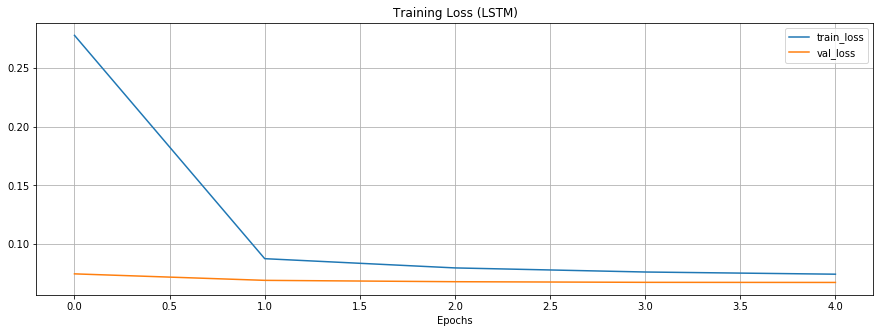

In [210]:
# Ploting the loss 
#history.history["loss"]

plt.figure(figsize=(15,5))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
# plt.plot(np.arange(0, N), history.history["precision"], label="train_precision")
# plt.plot(np.arange(0, N), history.history["val_precision"], label="val_precision")
# plt.plot(np.arange(0, N), history.history["recall"], label="train_recall")
# plt.plot(np.arange(0, N), history.history["val_recall"], label="val_recall")
# plt.plot(np.arange(0, N), history.history["f1"], label="train_f1")
# plt.plot(np.arange(0, N), history.history["val_f1"], label="val_f1")
plt.title("Training Loss (LSTM)")
plt.xlabel("Epochs")
plt.grid()
#plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

### CNN Model Results

#### Top 1 label prediction

In [215]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 1)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.1700671570195075
recall: 0.13218267927573973
f1: 0.14316825802914707


#### Top 2 labels prediction

In [216]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 2)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.1133674448353054
recall: 0.17169552438820104
f1: 0.13083837137882548


#### Top 10 labels prediction

In [217]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 10)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.06415733930284619
recall: 0.4851943898761935
f1: 0.11093627767793948


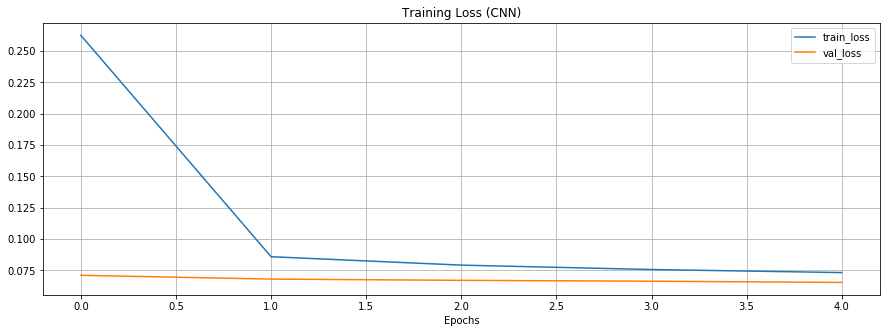

In [218]:
# Ploting the loss 
#history.history["loss"]

plt.figure(figsize=(15,5))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
# plt.plot(np.arange(0, N), history.history["precision"], label="train_precision")
# plt.plot(np.arange(0, N), history.history["val_precision"], label="val_precision")
# plt.plot(np.arange(0, N), history.history["recall"], label="train_recall")
# plt.plot(np.arange(0, N), history.history["val_recall"], label="val_recall")
# plt.plot(np.arange(0, N), history.history["f1"], label="train_f1")
# plt.plot(np.arange(0, N), history.history["val_f1"], label="val_f1")
plt.title("Training Loss (CNN)")
plt.xlabel("Epochs")
plt.grid()
#plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

### CNN+LSTM Model Results

#### Top 1 label prediction

In [231]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 1)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.07828589702590343
recall: 0.06595991898518282
f1: 0.06981984863020999


#### Top 2 labels prediction

In [232]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 2)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.07873361048928686
recall: 0.13352521053192626
f1: 0.09644996725904945


#### Top 10 labels prediction

In [233]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 10)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.05893827950111928
recall: 0.4444172872218923
f1: 0.10184245922690965


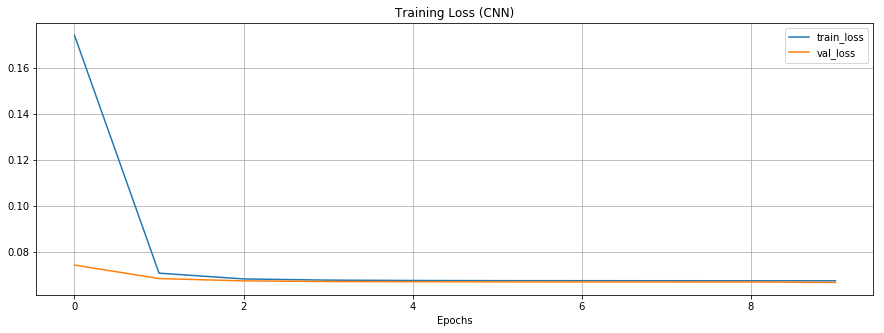

In [234]:
# Ploting the loss 
#history.history["loss"]

plt.figure(figsize=(15,5))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
# plt.plot(np.arange(0, N), history.history["precision"], label="train_precision")
# plt.plot(np.arange(0, N), history.history["val_precision"], label="val_precision")
# plt.plot(np.arange(0, N), history.history["recall"], label="train_recall")
# plt.plot(np.arange(0, N), history.history["val_recall"], label="val_recall")
# plt.plot(np.arange(0, N), history.history["f1"], label="train_f1")
# plt.plot(np.arange(0, N), history.history["val_f1"], label="val_f1")
plt.title("Training Loss (CNN)")
plt.xlabel("Epochs")
plt.grid()
#plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

### Error Analysis

In [ ]:
model.predict(X_test_seq)[100]

In [ ]:
for i in range(5):
    print(model.predict(X_test_seq)[i].argmax())
#model.predict(X_test_seq)[4].argmax()